<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

## Resumen del ejercicio:
Se realizaron cambios menores para que la notebook de pytorch al menos
pudiera completar la ejecucion.

El mas relevante fue enviar los inputs de la funcion `summary` al mismo `device`
```
encoder_input_data, decoder_input_data, decoder_output_data = data_set[0:1]
summary(model, input_data=(encoder_input_data.to(device), decoder_input_data.to(device)))
```
ademas fue necesario modificar la sintaxis para llamar al siguiente elemento de un iterador.

Por otro lado, para que la notebook pudiera correr en colab, fue necesario downgradear la version de `numpy` a una menor que 2.0.

Una vez solucionados los inconvenientes basicos, la notebook corre de principio a fin.

### DATASET REDUCIDO
Como se destacaba en el ejemplo, el modelo debia ser entrenado con dataset y embeddings reducidos por el acelerado incremento en el uso de RAM que impediria la ejecucion de la notebook.

Corriendo con los valores por defecto (un subconjunto de 6000 lineas del dataset -cantidad de frases-, vocabulario limitado a aproximadamente 8000, y longitudes de sentencia 16 y 18) el modelo lograba aprender y desempeñar bien en test y validacion, con puntajes de accuracy superiores a 0.7.

El problema con esto es que el conjunto reducido del set de entrenamiento tornaba inservible el modelo al momento de traducir. Un desempeño pauperrimo.

Como la accuracy del modelo al momento de entrenar se encontraba en un buen puntaje, se puede asumir que el problema no es de aprendizaje; y se podria argumentar que mejorar el modelo o lograr que la acuraccy suba a valores cercanos a 1 no iba a mejorar las traducciones generadas. Esto es asi porque el problema esta no en el aprendizaje sino en los datos empleados para el mismo.

Por ello se busco poder incrementar el tamanio del set de entrenamiento.

Sin embargo, con la notebook en el estado actual, la unica forma era
*finetunear* los valores de MAX_VOCAB_SIZE, MAX_NUM_SENTENCES, max_input_len y max_out_len de manera de lograr usar toda la ram posible, sin saturar.  Pero los numeros siguen siendo bajos en este approach (NUM_SENTENCES ~ 8000, VOCAB_SIZE ~ 10, y max input y output ~20). Con estos valores el comportamiento del modelo no cambia.

La accuracy sube un poco, pero al momento de generar traducciones el resultado es el mismo.
Pero es esperable, estamos en cualquier caso usando menos del 10% del set de frases para entrenar.

### PUSHING DATASET

Los esfuerzos se concentraron entonces en poder correr el modelo con un mejor set de entrenamiento. Monitoreando el uso de ram en la notebook se detecto que el pico de uso se producia al hace *onehot* para el encoder/decoder
  ```python
  self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()
  ```

  Modificando esa seccion, se puede cargar todo el dataset
```python
  MAX_NUM_SENTENCES = 118964
  MAX_VOCAB_SIZE = 27000
  max_input_len = 47
  max_out_len = 50
```

encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)

pero sin el one-hot, al cargar el dataset solo se usan 4gb de ram y la notebook se puede correr.

Evidentemente esto trae un nuevo problema que es que el tiempo de entrenamiento se dispara, se intento correr 1 epoch y el entrenamiento demoró mas de 1.30h

Por tal motivo se compatibilizo la notebook con colab, y se hicieron los cambios necesarios para correr en gpu y asi acelerar el entrenamiento ...

Como incluso usando GPU el tiempo de entrenamiento resultaba prohibitivo, se busco acelerar un poco el tiempo requerido.

Se modifico el paso forward del s2s vectorizando los decoders para no depender de un loop de python

se modifico esto:
```python
        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random
            # para ver en cada vuelta que técnica se aplica
            #input = top1            

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs
```
```python
    def forward(self, encoder_input, decoder_input):
        prev_state = self.encoder(encoder_input)
        decoder_output, _ = self.decoder.lstm(self.decoder.embedding(decoder_input), prev_state)
        out = self.decoder.fc1(decoder_output)
        return out
```

no estoy seguro de si esto rompe la consigna, pero de otra forma no pude
entrenar con todo el dataset.

De esta forma se redujo notablemente el tiempo de entrenamiento, en colab GPU, 10 epochs en unos minutos. En CPU unos 10 minutos por ecpoh, manejable.

## Resultados

Al final de la notebook se pueden ver las traducciones realizadas con todo el dataset. Si bien no se dispone de una medida rigurosa,
podria decirse que el traductor "mejoro" (con algo de generosidad).
Sin embargo, sigue fallando en tareas sencillas.

Ejemplos:
-
========================================

Input: You can never be too careful.

Response: no puedes ser más cuidadoso

========================================

Input: Don't pretend what you don't feel.

Response: no te preocupes por lo que quieras

========================================

Input: They mean well.

Response: tom se ve bien

========================================

Input: Tom was here all day.

Response: tom estaba teniendo un día

========================================

Input: We are dreaming of a better future.

Response: nos estamos quedando dormidos en una granja

========================================

Algo que se nota es que Tom esta sobrerepresentado en las traducciones

## Otras frases

========================================

Input: the cat is under the table

Response: el gato está en la mesa

========================================

Input: the bus is blue

Response: el libro es azul

========================================

Input: the car is under the table

Response: el gato está en la mesa

========================================

Input: big house

Response: traed ayuda

========================================

Puede verse un patron en como se equivoca... mira la primer letra de las palabras (seran palabras que no conoce?)
por ejemplo  Bus > Book
en "the car".. confunde con "the Cat"

"big house" > "Bring Help" > "traed ayuda" (??) podria ser

Pregunta, que pasa si le pasamos letras solas??

Input: A | Response: ¡atacad

Input: B | Response: ¡corre

Input: C | Response: ¡felicidades

Input: D | Response: ¡eso

Input: F | Response: ¡disparad

Input: G | Response: vete

Input: H | Response: besado

Input: I | Response: está fuera

Input: J | Response: ¡salta

Input: K | Response: besado

Input: L | Response: escuchen

Input: M | Response: tom

Input: N | Response: ahora

Input: O | Response: ¡órale

Input: P | Response: continúa

Input: Q | Response: besado

Input: R | Response: ¡corre

Input: S | Response: ¡parad

Input: T | Response: ¡genial

En la mayoria se ve este patron, mira esa letra y extrapola: A > Attack, C > Congratulations, F > Fire!, G > Go, J > Jump, L > listen
(igual para Now, Stop, Run)

In [1]:
%pip install --upgrade --no-cache-dir gdown --quiet
%pip install torchinfo


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
from torchinfo import summary

In [5]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [6]:
def sequence_acc(output, target):
    predictions = output.argmax(dim=-1) 
    
    correct = (predictions == target).float()

    
    accuracy = correct.mean()
    return accuracy

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            
            train_encoder_input = train_encoder_input.to(device)
            train_decoder_input = train_decoder_input.to(device)
            train_target = train_target.to(device)

            # Seteo los gradientes en cero
            optimizer.zero_grad()

            # Forward pass
            output = model(train_encoder_input, train_decoder_input)

            loss = criterion(output.reshape(-1, output.shape[-1]), 
                           train_target.reshape(-1))
            
            # Almaceno el error del batch
            epoch_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        with torch.no_grad():
            valid_encoder_input, valid_decoder_input, valid_target = next(iter(valid_loader))
            valid_encoder_input = valid_encoder_input.to(device)
            valid_decoder_input = valid_decoder_input.to(device)
            valid_target = valid_target.to(device)
            
            output = model(valid_encoder_input, valid_decoder_input)
            
            # NEW: Efficient validation loss
            epoch_valid_loss = criterion(output.reshape(-1, output.shape[-1]), 
                                       valid_target.reshape(-1))
            epoch_valid_loss = epoch_valid_loss.item()
            valid_loss.append(epoch_valid_loss)

            # Calculo el accuracy de la epoch
            epoch_valid_accuracy = sequence_acc(output, valid_target).item()
            valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### 1 - Datos

In [7]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q spa-eng.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [8]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 118964

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964


In [9]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [10]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 27000

In [11]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47


In [12]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50


In [13]:
print(len(word2idx_outputs))
num_words_output

26341


26342

Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [14]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 47
max_out_len = 50

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [15]:
from torch_helpers import pad_sequences
print(np.version.full_version)
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

1.26.4
Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)


In [16]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (118964, 50)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategía que se transformó la entrada del decoder.

In [17]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([118964, 50])

In [18]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Store as integer tensors with dtype int64 (long)
        self.decoder_outputs = torch.from_numpy(decoder_output.astype(np.int64))  # Change to int64
        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self, index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)


encoder_input_size: 47
decoder_input_size: 50


In [19]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 95172
Tamaño del conjunto de validacion: 23792


### 3 - Preparar los embeddings

In [20]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [21]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [22]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [23]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 218


In [24]:
nb_words

13524

In [25]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(13524, 50)

### 4 - Entrenar el modelo

In [29]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.fc1(lstm_output[:, -1, :]) 
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        prev_state = self.encoder(encoder_input)
        decoder_output, _ = self.decoder.lstm(self.decoder.embedding(decoder_input), prev_state)
        out = self.decoder.fc1(decoder_output)
        return out 

encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda: model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
if cuda:
    criterion = criterion.to(device)
encoder_input_data, decoder_input_data, decoder_output_data = data_set[0:1]
summary(model, input_data=(encoder_input_data.to(device), decoder_input_data.to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 47, 50]               (676,200)
│    └─LSTM: 2-2                         [1, 47, 128]              92,160
├─Decoder: 1-2                           --                        --
│    └─Embedding: 2-3                    [1, 50, 50]               1,317,100
│    └─LSTM: 2-4                         [1, 50, 128]              92,160
│    └─Linear: 2-5                       [1, 50, 26342]            3,398,118
Total params: 5,575,738
Trainable params: 4,899,538
Non-trainable params: 676,200
Total mult-adds (M): 14.33
Input size (MB): 46.16
Forward/backward pass size (MB): 10.67
Params size (MB): 22.30
Estimated Total Size (MB): 79.14

In [30]:
history1 = train(model,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=10
                )

Epoch: 1/10 - Train loss 0.832 - Train accuracy 0.885 - Valid Loss 0.642 - Valid accuracy 0.899
Epoch: 2/10 - Train loss 0.601 - Train accuracy 0.901 - Valid Loss 0.569 - Valid accuracy 0.904
Epoch: 3/10 - Train loss 0.531 - Train accuracy 0.907 - Valid Loss 0.534 - Valid accuracy 0.908
Epoch: 4/10 - Train loss 0.485 - Train accuracy 0.911 - Valid Loss 0.512 - Valid accuracy 0.911
Epoch: 5/10 - Train loss 0.449 - Train accuracy 0.913 - Valid Loss 0.503 - Valid accuracy 0.914
Epoch: 6/10 - Train loss 0.421 - Train accuracy 0.916 - Valid Loss 0.487 - Valid accuracy 0.915
Epoch: 7/10 - Train loss 0.398 - Train accuracy 0.918 - Valid Loss 0.487 - Valid accuracy 0.916
Epoch: 8/10 - Train loss 0.379 - Train accuracy 0.921 - Valid Loss 0.481 - Valid accuracy 0.917
Epoch: 9/10 - Train loss 0.363 - Train accuracy 0.923 - Valid Loss 0.473 - Valid accuracy 0.916
Epoch: 10/10 - Train loss 0.349 - Train accuracy 0.925 - Valid Loss 0.481 - Valid accuracy 0.915


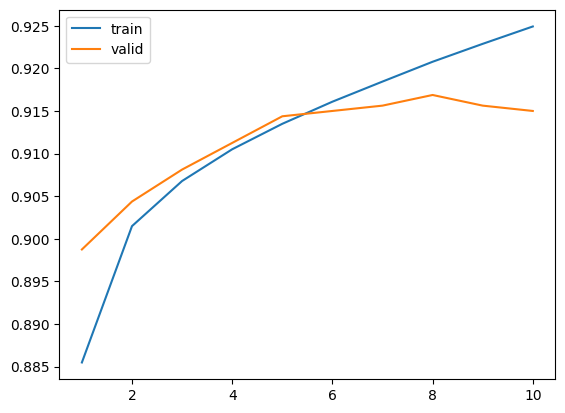

In [31]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [32]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [143]:
input_test = "My friend is in jail"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

# Se obtiene la salida del encoder (el estado oculto para el decoder)
prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

# Se inicializa la secuencia de entrada al decoder como ""
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

# Se obtiene la primera palabra de la secuencia de salida del decoder
output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())
print("Index/token de salida:", idx)

word = idx2word_target[idx]
print("Palabra de salida:", word)
     


Input: My friend is in jail
Representacion en vector de tokens de ids [18, 234, 7, 9, 1674]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
    18  234    7    9 1674]]
Index/token de salida: 21
Palabra de salida: mi


In [38]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    prev_state = model.encoder(encoder_sequence_test_tensor.to(device))

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output, new_prev_state = model.decoder(target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar ídx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)

In [135]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))

translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [18, 199, 126, 2318]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   18  199  126 2318]]
Response: mi madre le hizo daño


In [42]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: You can never be too careful.
Response: no puedes ser más cuidadoso


In [105]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: Don't pretend what you don't feel.
Response: no te preocupes por lo que quieras


In [125]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: They mean well.
Response: tom se ve bien


In [169]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
translation = translate_sentence(encoder_sequence_test_tensor)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: We are dreaming of a better future.
Response: nos estamos quedando dormidos en una granja


In [170]:
input_test = "the cat is under the table"
print("Input:", input_test) 
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: the cat is under the table
Response: el gato está en la mesa


In [258]:
input_test = "the bus is blue"
print("Input:", input_test) 
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: the bus is blue
Response: el libro es azul


In [259]:
input_test = "the car is under the table"
print("Input:", input_test) 
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: the car is under the table
Response: el gato está en la mesa


In [262]:
input_test = "big house"
print("Input:", input_test) 
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: big house
Response: traed ayuda


In [272]:
for l in ["A", "B", "C", "D", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T" ]:
    
    input_test = l
  
    integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    encoder_sequence_test_tensor = torch.from_numpy(encoder_sequence_test.astype(np.int32))
    translation = translate_sentence(encoder_sequence_test)
    print(f"\nInput: {input_test} | Response: {translation}" ) 



Input: A | Response: ¡atacad

Input: B | Response: ¡corre

Input: C | Response: ¡felicidades

Input: D | Response: ¡eso

Input: F | Response: ¡disparad

Input: G | Response: vete

Input: H | Response: besado

Input: I | Response: está fuera

Input: J | Response: ¡salta

Input: K | Response: besado

Input: L | Response: escuchen

Input: M | Response: tom

Input: N | Response: ahora

Input: O | Response: ¡órale

Input: P | Response: continúa

Input: Q | Response: besado

Input: R | Response: ¡corre

Input: S | Response: ¡parad

Input: T | Response: ¡genial
